100%|██████████| 500/500 [00:00<00:00, 1020.98it/s]


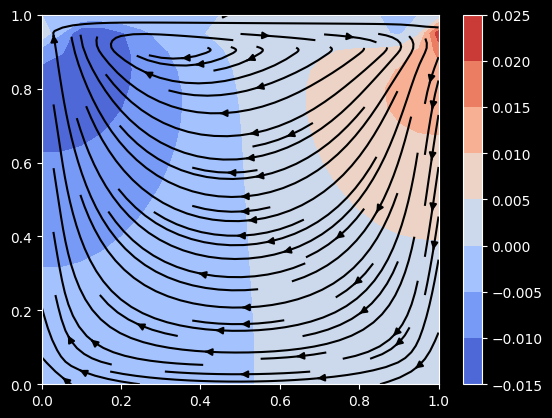

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

N_POINTS = 41
DOMAIN_SIZE = 1.0
N_ITERATIONS = 500
TIME_STEP_LENGTH = 0.001
KINEMATIC_VISCOSITY = 0.001
DENSITY = 1.0
HORIZONTAL_VELOCITY_TOP = 1.0

N_PRESSURE_POISSON_ITERATIONS = 50
STABILITY_SAFETY_FACTOR = 0.5

def main():
    element_length = DOMAIN_SIZE / (N_POINTS - 1) #uniform discretization
    x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

    X, Y = np.meshgrid(x, y) #2d mesh

    u_prev = np.zeros_like(X) #initial conditions u v p
    v_prev = np.zeros_like(X)
    p_prev = np.zeros_like(X)

    #partial difference wrt x and y
    def central_difference_x(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 2:  ]
            -
            f[1:-1, 0:-2]
        ) / (
            2 * element_length
        )
        return diff
    
    def central_difference_y(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[2:  , 1:-1]
            -
            f[0:-2, 1:-1]
        ) / (
            2 * element_length
        )
        return diff
    
    #laplace operator 5point stencil
    def laplace(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 0:-2]
            +
            f[0:-2, 1:-1]
            -
            4
            *
            f[1:-1, 1:-1]
            +
            f[1:-1, 2:  ]
            +
            f[2:  , 1:-1]
        ) / (
            element_length**2
        )
        return diff
    

    maximum_possible_time_step_length = (
        0.5 * element_length**2 / KINEMATIC_VISCOSITY
    )
    if TIME_STEP_LENGTH > STABILITY_SAFETY_FACTOR * maximum_possible_time_step_length:
        raise RuntimeError("Stability is not guarenteed")

    
    for _ in tqdm(range(N_ITERATIONS)):
        d_u_prev__d_x = central_difference_x(u_prev)
        d_u_prev__d_y = central_difference_y(u_prev)
        d_v_prev__d_x = central_difference_x(v_prev)
        d_v_prev__d_y = central_difference_y(v_prev)
        laplace__u_prev = laplace(u_prev)
        laplace__v_prev = laplace(v_prev)

        # tentative step by solving the momentum equation without the
        # pressure gradient using a simple forward euler
        u_tent = (
            u_prev
            +
            TIME_STEP_LENGTH * (
                -
                (
                    u_prev * d_u_prev__d_x
                    +
                    v_prev * d_u_prev__d_y
                )
                +
                KINEMATIC_VISCOSITY * laplace__u_prev
            )
        )
        v_tent = (
            v_prev
            +
            TIME_STEP_LENGTH * (
                -
                (
                    u_prev * d_v_prev__d_x
                    +
                    v_prev * d_v_prev__d_y
                )
                +
                KINEMATIC_VISCOSITY * laplace__v_prev
            )
        )

        # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
        # except for the horizontal velocity at the top, which is prescribed
        u_tent[0, :] = 0.0
        u_tent[:, 0] = 0.0
        u_tent[:, -1] = 0.0
        u_tent[-1, :] = HORIZONTAL_VELOCITY_TOP
        v_tent[0, :] = 0.0
        v_tent[:, 0] = 0.0
        v_tent[:, -1] = 0.0
        v_tent[-1, :] = 0.0


        d_u_tent__d_x = central_difference_x(u_tent)
        d_v_tent__d_y = central_difference_y(v_tent)

        #  pressure correction by solving the pressure-poisson equation
        rhs = (
            DENSITY / TIME_STEP_LENGTH
            *
            (
                d_u_tent__d_x
                +
                d_v_tent__d_y
            )
        )

        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            p_next = np.zeros_like(p_prev)
            p_next[1:-1, 1:-1] = 1/4 * (
                +
                p_prev[1:-1, 0:-2]
                +
                p_prev[0:-2, 1:-1]
                +
                p_prev[1:-1, 2:  ]
                +
                p_prev[2:  , 1:-1]
                -
                element_length**2
                *
                rhs[1:-1, 1:-1]
            )

            # Pressure Boundary Conditions: Homogeneous Neumann Boundary
            # Conditions everywhere except for the top, where it is a cavity
            # homogeneous Dirichlet BC
            p_next[:, -1] = p_next[:, -2]
            p_next[0,  :] = p_next[1,  :]
            p_next[:,  0] = p_next[:,  1]
            p_next[-1, :] = 0.0

            p_prev = p_next
        

        d_p_next__d_x = central_difference_x(p_next)
        d_p_next__d_y = central_difference_y(p_next)

        # Correct the velocities such that the fluid stays incompressible
        u_next = (
            u_tent
            -
            TIME_STEP_LENGTH / DENSITY
            *
            d_p_next__d_x
        )
        v_next = (
            v_tent
            -
            TIME_STEP_LENGTH / DENSITY
            *
            d_p_next__d_y
        )

        # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
        # except for the horizontal velocity at the top, which is prescribed
        u_next[0, :] = 0.0
        u_next[:, 0] = 0.0
        u_next[:, -1] = 0.0
        u_next[-1, :] = HORIZONTAL_VELOCITY_TOP
        v_next[0, :] = 0.0
        v_next[:, 0] = 0.0
        v_next[:, -1] = 0.0
        v_next[-1, :] = 0.0


        # Advance in time
        u_prev = u_next
        v_prev = v_next
        p_prev = p_next
    

    # The [::2, ::2] selects only every second entry (less cluttering plot)
    plt.style.use("dark_background")
    plt.figure()
    plt.contourf(X[::2, ::2], Y[::2, ::2], p_next[::2, ::2], cmap="coolwarm")
    plt.colorbar()

    #plt.quiver(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
    plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.show()


if __name__ == "__main__":
    main()